['l1.png', 'l2.png', 'l3.png', 'r1.png', 'r2.png', 'r3.png']


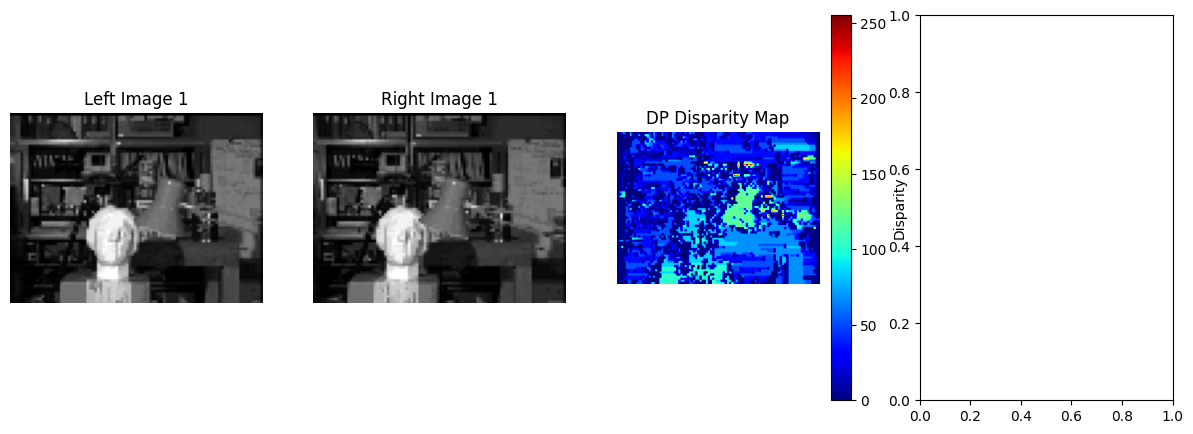

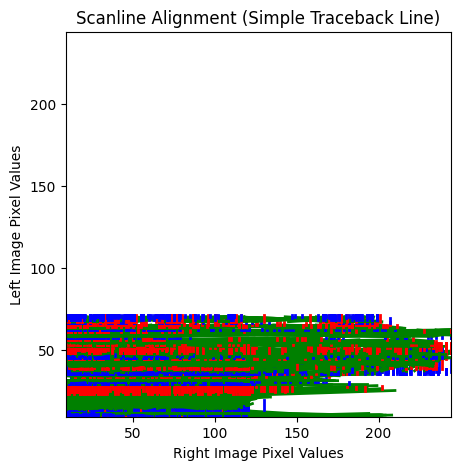

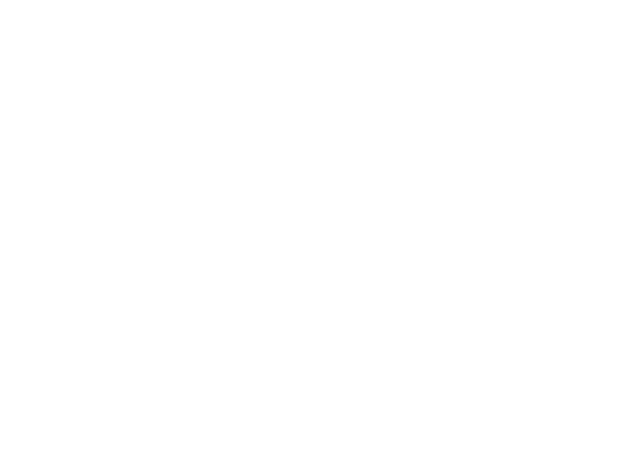

Disparity Cost Matrix (D) for image pair 1:
[[ 4.    5.    6.   ... 97.   98.   99.  ]
 [ 5.    6.    7.   ... 96.25 97.25 98.25]
 [ 6.    7.    8.   ... 95.5  96.5  97.5 ]
 ...
 [97.   96.25 95.25 ... 92.5  93.5  94.5 ]
 [98.   97.25 96.25 ... 93.5  93.5  94.5 ]
 [99.   98.25 97.25 ... 94.5  94.5  93.75]]


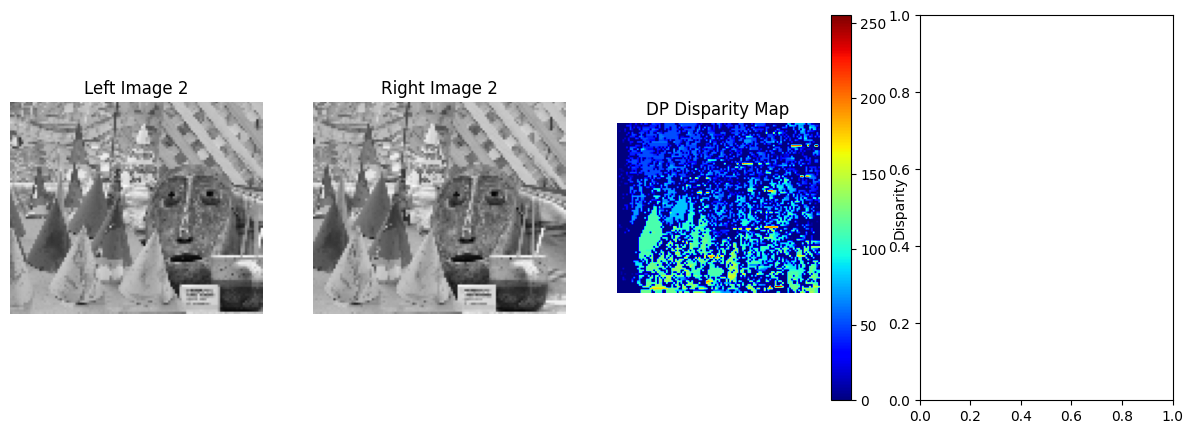

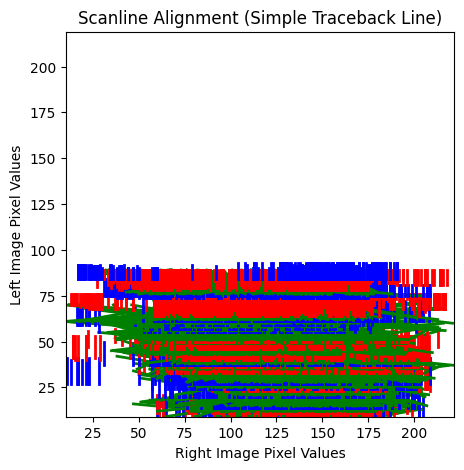

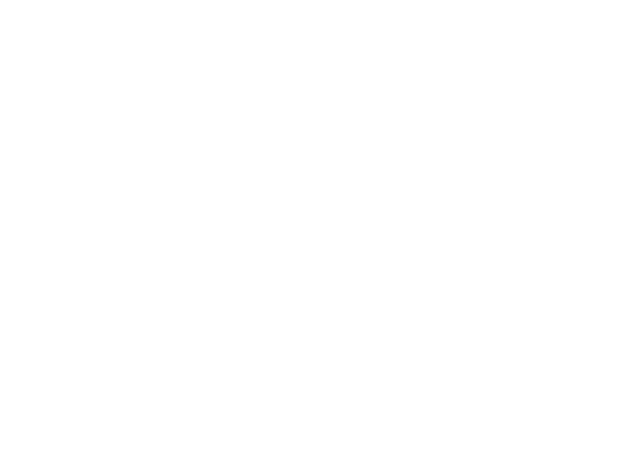

Disparity Cost Matrix (D) for image pair 2:
[[110.25 111.25 112.25 ... 219.25 220.25 221.25]
 [111.25 112.25 113.25 ... 218.5  219.5  220.5 ]
 [112.25 113.25 114.25 ... 218.5  219.5  220.5 ]
 ...
 [219.25 218.25 217.25 ... 228.25 229.25 230.25]
 [220.25 219.25 218.25 ... 227.5  228.5  229.5 ]
 [221.25 220.25 219.25 ... 228.5  229.5  230.5 ]]


KeyboardInterrupt: 

In [5]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt


def compute_disparity_dp(lI, rI, sigma=2, c0=1):
    h, w = lI.shape
    left_disp_map = np.zeros_like(lI, dtype=np.float32)
    right_disp_map = np.zeros_like(rI, dtype=np.float32)

    for row in range(h):
        Il = lI[row].astype(np.float32)
        Ir = rI[row].astype(np.float32)
        N = len(Il)  # Width of the image row, this should be equal to 'w'
        D = np.zeros((N, N), dtype=np.float32)

        # Cost matrix initialization
        for i in range(N):
            for j in range(N):
                dij = ((Il[i] - Ir[j]) ** 2) / (sigma ** 2)
                if i == 0 and j == 0:
                    D[i, j] = dij
                elif i == 0:
                    D[i, j] = D[i, j-1] + c0
                elif j == 0:
                    D[i, j] = D[i-1, j] + c0
                else:
                    D[i, j] = min(
                        D[i-1, j-1] + dij,
                        D[i-1, j] + c0,
                        D[i, j-1] + c0
                    )

        # Backtracking to compute disparity maps and track the path
        i, j = N - 1, N - 1
        path = []  # To store the path for alignment visualization
        while i > 0 and j > 0:
            cost = D[i, j]
            dij = ((Il[i] - Ir[j]) ** 2) / (sigma ** 2)
            if cost == D[i-1, j-1] + dij:
                disp = abs(i - j)
                left_disp_map[row, i] = disp
                right_disp_map[row, j] = disp
                path.append(('match', i, j))  # Diagonal move (match)
                i -= 1
                j -= 1
            elif cost == D[i-1, j] + c0:
                path.append(('skip_ir', i, j))  # Vertical move (skip in right image)
                i -= 1
            else:
                path.append(('skip_il', i, j))  # Horizontal move (skip in left image)
                j -= 1

        # Reverse the path to make it start from (1,1)
        path.reverse()

    return left_disp_map, right_disp_map, D, path


def read_images_from_folder(folder_path):
    images = []
    filenames = sorted([f for f in os.listdir(folder_path) if f.endswith('.png')])
    print(filenames)
    
    for filename in filenames:
        image = cv2.imread(os.path.join(folder_path, filename))
        if image is not None:
            # Convert to grayscale
            image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            images.append(image_gray)
    return images

def plot_traceback(path, Il, Ir):
    """
    Plot a simple line for the traceback path.
    Only a single line is drawn for each move (diagonal, vertical, or horizontal).
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    
    for action, i, j in path:
        # Ensure that we do not go out of bounds
        if i >= len(Il) or j >= len(Ir):
            continue

        if action == 'match':
            # Diagonal (match) - draw a line connecting matching pixels
            ax.plot([Ir[j], Il[i]], [j, i], color='g', linestyle='-', linewidth=2)
        elif action == 'skip_il':
            # Vertical move (skip in left image) - draw a line at the same position in the left
            ax.plot([Ir[j], Ir[j]], [i, j], color='r', linestyle='-', linewidth=2)
        elif action == 'skip_ir':
            # Horizontal move (skip in right image) - draw a line at the same position in the right
            ax.plot([Il[i], Il[i]], [i, j], color='b', linestyle='-', linewidth=2)

    ax.set_xlabel('Right Image Pixel Values')
    ax.set_ylabel('Left Image Pixel Values')
    ax.set_title('Scanline Alignment (Simple Traceback Line)')
    ax.set_xlim([np.min(Ir), np.max(Ir)])
    ax.set_ylim([np.min(Il), np.max(Il)])
    ax.set_aspect('equal', adjustable='box')
    plt.show()


def process_images(folder_path):
    images = read_images_from_folder(folder_path)
    
    if len(images) % 2 != 0:
        print("Please make sure the folder contains an even number of images (left-right pairs).")
        return

    # Split images into left and right image groups
    left_images = images[:len(images)//2]   # First half are left images
    right_images = images[len(images)//2:]  # Second half are right images
    
    for i in range(len(left_images)):
        lI = left_images[i]      # Left image
        rI = right_images[i]     # Right image
        
        # Resize both images to match each other if necessary
        if lI.shape != rI.shape:
            print("Resizing right image to match the left image's dimensions.")
            rI = cv2.resize(rI, (lI.shape[1], lI.shape[0]))  # Resize to match left image size
            
        # Resize both images to downscaled resolution (using a smaller factor)
        lI_resized = cv2.resize(lI, (0, 0), fx=0.25, fy=0.25)
        rI_resized = cv2.resize(rI, (0, 0), fx=0.25, fy=0.25)
        
        # Apply Gaussian smoothing (blurring) with a smaller kernel to preserve details
        lI_smoothed = cv2.GaussianBlur(lI_resized, (3, 3), 0)
        rI_smoothed = cv2.GaussianBlur(rI_resized, (3, 3), 0)

        # Compute disparity using dynamic programming on smoothed images
        dp_left_disp_map, dp_right_disp_map, D_matrix, traceback_path = compute_disparity_dp(lI_smoothed, rI_smoothed)
        normalized_disparity = cv2.normalize(dp_left_disp_map, None, 0, 255, cv2.NORM_MINMAX)

        # Create a figure with 4 subplots: left image, right image, disparity map, and traceback
        plt.figure(figsize=(15, 5))

        # Plot the left image
        plt.subplot(1, 4, 1)
        plt.imshow(lI_resized, cmap='gray')
        plt.title(f"Left Image {i+1}")
        plt.axis('off')

        # Plot the right image
        plt.subplot(1, 4, 2)
        plt.imshow(rI_resized, cmap='gray')
        plt.title(f"Right Image {i+1}")
        plt.axis('off')

        # Plot the disparity map
        plt.subplot(1, 4, 3)
        plt.imshow(normalized_disparity.astype(np.uint8), cmap='jet')
        plt.colorbar(label='Disparity')
        plt.title("DP Disparity Map")
        plt.axis('off')

        # Plot the traceback path
        plt.subplot(1, 4, 4)
        plot_traceback(traceback_path, lI_resized, rI_resized)
        plt.axis('off')

        # Show the plot
        plt.tight_layout()
        plt.show()

        # Print the disparity cost matrix (D)
        print(f"Disparity Cost Matrix (D) for image pair {i+1}:")
        print(D_matrix)

# Example usage
folder_path = "images"  # Replace with the path to your image folder
process_images(folder_path)


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

def compute_disparity_dp(lI, rI, sigma=2, c0=1):
    h, w = lI.shape
    left_disp_map = np.zeros_like(lI, dtype=np.float32)
    right_disp_map = np.zeros_like(rI, dtype=np.float32)

    for row in range(h):
        Il = lI[row].astype(np.float32)
        Ir = rI[row].astype(np.float32)
        N = len(Il)  # Width of the image row, this should be equal to 'w'
        D = np.zeros((N, N), dtype=np.float32)

        # Cost matrix initialization
        for i in range(N):
            for j in range(N):
                dij = ((Il[i] - Ir[j]) ** 2) / (sigma ** 2)
                if i == 0 and j == 0:
                    D[i, j] = dij
                elif i == 0:
                    D[i, j] = D[i, j-1] + c0
                elif j == 0:
                    D[i, j] = D[i-1, j] + c0
                else:
                    D[i, j] = min(
                        D[i-1, j-1] + dij,
                        D[i-1, j] + c0,
                        D[i, j-1] + c0
                    )

        # Backtracking to compute disparity maps and track the path
        i, j = N - 1, N - 1
        moves = []  # To store the moves ('d', 'l', 'r')

        while i > 0 and j > 0:
            cost = D[i, j]
            dij = ((Il[i] - Ir[j]) ** 2) / (sigma ** 2)
            if cost == D[i-1, j-1] + dij:
                disp = abs(i - j)
                left_disp_map[row, i] = disp
                right_disp_map[row, j] = disp
                moves.append('d')  # Diagonal move (match)
                i -= 1
                j -= 1
            elif cost == D[i-1, j] + c0:
                moves.append('l')  # Left move (skip in right image)
                i -= 1
            else:
                moves.append('r')  # Right move (skip in left image)
                j -= 1

        # Reverse the moves to make it start from (1,1)
        moves.reverse()

    return left_disp_map, right_disp_map, D, moves

def read_images_from_folder(folder_path):
    images = []
    filenames = sorted([f for f in os.listdir(folder_path) if f.endswith('.png')])
    print(filenames)
    
    for filename in filenames:
        image = cv2.imread(os.path.join(folder_path, filename))
        if image is not None:
            # Convert to grayscale
            image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            images.append(image_gray)
    return images

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_traceback(moves):
    """
    Plot the traceback path based on the moves list.
    'd' = diagonal (match), 'l' = left (skip down), 'r' = right (skip right)
    Starts from (1, 1) and plots the movement path.
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    
    # Starting point at (1, 1)
    i, j = 1, 1
    x_vals, y_vals = [j], [i]  # Store the coordinates for plotting

    for move in moves:
        if move == 'd':  # Diagonal move (match)
            i += 1
            j += 1
        elif move == 'l':  # Left move (skip down)
            j += 1
        elif move == 'r':  # Right move (skip right)
            i += 1
        
        x_vals.append(j)
        y_vals.append(i)

    ax.plot(x_vals, y_vals, color='b', linestyle='-', linewidth=2)  # Plot the path as a line

    ax.set_xlabel('Right Image Pixel Values (j)')
    ax.set_ylabel('Left Image Pixel Values (i)')
    ax.set_title('Traceback Path')
    ax.set_aspect('equal', adjustable='box')
    plt.show()

def process_images(folder_path):
    images = read_images_from_folder(folder_path)
    
    if len(images) % 2 != 0:
        print("Please make sure the folder contains an even number of images (left-right pairs).")
        return

    # Split images into left and right image groups
    left_images = images[:len(images)//2]   # First half are left images
    right_images = images[len(images)//2:]  # Second half are right images
    
    for i in range(len(left_images)):
        lI = left_images[i]      # Left image
        rI = right_images[i]     # Right image
        
        # Resize both images to match each other if necessary
        if lI.shape != rI.shape:
            print("Resizing right image to match the left image's dimensions.")
            rI = cv2.resize(rI, (lI.shape[1], lI.shape[0]))  # Resize to match left image size
            
        # Resize both images to downscaled resolution (using a smaller factor)
        lI_resized = cv2.resize(lI, (0, 0), fx=0.25, fy=0.25)
        rI_resized = cv2.resize(rI, (0, 0), fx=0.25, fy=0.25)
        
        # Apply Gaussian smoothing (blurring) with a smaller kernel to preserve details
        lI_smoothed = cv2.GaussianBlur(lI_resized, (3, 3), 0)
        rI_smoothed = cv2.GaussianBlur(rI_resized, (3, 3), 0)

        # Compute disparity using dynamic programming on smoothed images
        dp_left_disp_map, dp_right_disp_map, D_matrix, moves = compute_disparity_dp(lI_smoothed, rI_smoothed)
        normalized_disparity = cv2.normalize(dp_left_disp_map, None, 0, 255, cv2.NORM_MINMAX)

        # Create a figure with 4 subplots: left image, right image, disparity map, and traceback
        plt.figure(figsize=(15, 5))

        # Plot the left image
        plt.subplot(1, 4, 1)
        plt.imshow(lI_resized, cmap='gray')
        plt.title(f"Left Image {i+1}")
        plt.axis('off')

        # Plot the right image
        plt.subplot(1, 4, 2)
        plt.imshow(rI_resized, cmap='gray')
        plt.title(f"Right Image {i+1}")
        plt.axis('off')

        # Plot the disparity map
        plt.subplot(1, 4, 3)
        plt.imshow(normalized_disparity.astype(np.uint8), cmap='jet')
        plt.colorbar(label='Disparity')
        plt.title("DP Disparity Map")
        plt.axis('off')

        # Plot the traceback path
        plt.subplot(1, 4, 4)
        plot_traceback(moves)
        plt.axis('off')

        # Show the plot
        plt.tight_layout()
        plt.show()

        # Print the disparity cost matrix (D)
        print(f"Disparity Cost Matrix (D) for image pair {i+1}:")
        print(D_matrix)

# Example usage
folder_path = "images"  # Replace with the path to your image folder
process_images(folder_path)
